In [1]:
# https://mail.google.com/mail/u/0/#inbox/QgrcJHrnscJGjsRzFLPzmGMZSlGWKMsntRB

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from childes_mi.utils.paths import DATA_DIR, ensure_dir, DROSOPHILA_DIR
import urllib.request

In [4]:
from tqdm.autonotebook import tqdm
import h5py
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
mat_file = list(DROSOPHILA_DIR.glob('*.mat'))[0]
mat_file

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/childes_mi_project/data/raw/DROSOPHILA_Data_Dir/transition_data.mat')

In [6]:
ds = scipy.io.loadmat(mat_file.as_posix())

In [7]:
ds.keys()

dict_keys(['__header__', '__version__', '__globals__', 'density', 'transition_states', 'xx', 'peakPoints', 'regionMap'])

In [8]:
ds['transition_states'][0]

array([array([[59],
       [43],
       [11],
       ...,
       [43],
       [40],
       [44]], dtype=uint8)], dtype=object)

In [9]:
states = [np.concatenate(np.concatenate(i)) for i in ds['transition_states']]

In [10]:
states[0]

array([59, 43, 11, ..., 43, 40, 44], dtype=uint8)

In [11]:
len(states[0])

10803

In [12]:
state_lens = [len(i) for i in states]

(array([ 3.,  1.,  6.,  8., 18., 11.,  8.,  3.,  0.,  1.]),
 array([ 7447. ,  8181.3,  8915.6,  9649.9, 10384.2, 11118.5, 11852.8,
        12587.1, 13321.4, 14055.7, 14790. ]),
 <a list of 10 Patch objects>)

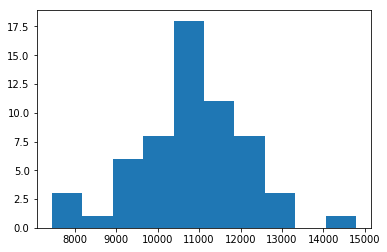

In [13]:
plt.hist(state_lens)

In [14]:
bouts_indv = [["{}_{}".format(bi, element) for element in bout] for bi, bout in enumerate(tqdm(states))]

### Mutual information

In [15]:
from childes_mi.information_theory import mutual_information as mi

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.cluster.supervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.cluster.expected_mutual_info_fast module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [16]:
distances = np.arange(1,1001)

In [17]:
(MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
    bouts_indv, distances=distances, n_jobs=-1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   21.9s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   25.8s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   20.2s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   24.3s finished


In [18]:
MI_DF = pd.DataFrame(
    [[MI, MI_var, shuff_MI, shuff_MI_var, distances]],
    columns=["MI", "MI_var", "shuff_MI", "shuff_MI_var", "distances"],
)

In [19]:
MI_DF.to_pickle(DATA_DIR / "mi" / "drosophila_mi_1000.pickle")

In [20]:
row = MI_DF.iloc[0]

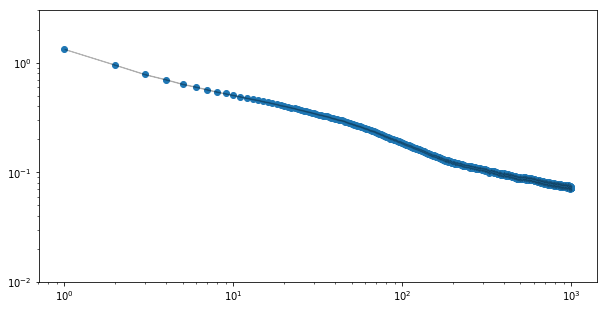

In [21]:
fig, ax = plt.subplots(figsize=(10,5))
MI = row.MI-row.shuff_MI
MI_var = row.MI_var

ax.scatter(distances, MI)
ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
ax.set_ylim([1e-2, 3])
ax.set_yscale('log')
ax.set_xscale('log')

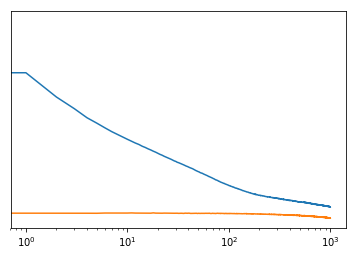

In [22]:
plt.loglog(row.MI)
plt.loglog(row.shuff_MI)

### no repeats

In [59]:
from childes_mi.information_theory import model_fitting as mf

In [60]:
def remove_repeats(sequence):
    a = np.array(sequence[1:])
    b = np.array(sequence[:-1])
    c = [sequence[0]] + list(a[a != b])
    return c

In [61]:
bouts_indv_no_repeats = [remove_repeats(i) for i in bouts_indv]

In [62]:
distances = np.arange(1,1001)

In [63]:
(MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
    bouts_indv_no_repeats, distances=distances, n_jobs=-1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   22.1s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   25.9s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   20.3s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   24.4s finished


In [64]:
MI_DF = pd.DataFrame(
    [[MI, MI_var, shuff_MI, shuff_MI_var, distances]],
    columns=["MI", "MI_var", "shuff_MI", "shuff_MI_var", "distances"],
)

In [65]:
MI_DF.to_pickle(DATA_DIR / "mi" / "drosophila_mi_1000_no_repeats.pickle")

In [43]:
MI_DF[:10]

,MI,MI_var,shuff_MI,shuff_MI_var,distances
0,"[11.490855469682131, 11.113366318302845, 10.94...","[0.0032101072658640537, 0.003149172574458995, ...","[10.161265630190066, 10.161671030084161, 10.16...","[0.0030512739505473203, 0.003051607421549551, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [44]:
row = MI_DF.iloc[0]

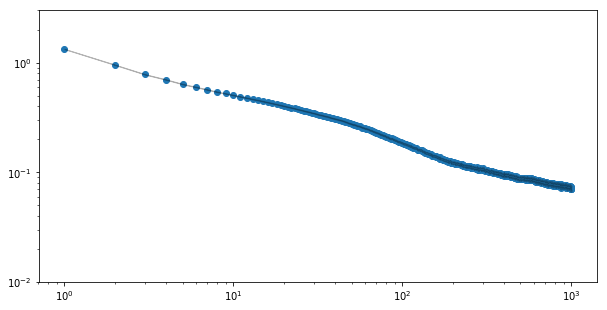

In [45]:
fig, ax = plt.subplots(figsize=(10,5))
MI = row.MI-row.shuff_MI
MI_var = row.MI_var

ax.scatter(distances, MI)
ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
ax.set_ylim([1e-2, 3])
ax.set_yscale('log')
ax.set_xscale('log')

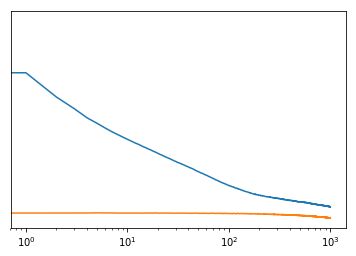

In [46]:
plt.loglog(row.MI)
plt.loglog(row.shuff_MI)

In [47]:
MI_DF = MI_DF.assign(**{i:np.nan for i in ['exp_results', 'pow_results', 'concat_results',
     'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
     'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak']})
MI_DF['curvature'] = MI_DF['curvature'].astype(object)

In [48]:
n = 100 # max distance for computation
for idx, row in tqdm(MI_DF.iterrows(), total=len(MI_DF)):
    # get signal
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    sig = sig
    
    # fit models
    results_power, results_exp, results_pow_exp, best_fit_model = mf.fit_models(distances, sig)
    
    # get fit results
    R2_exp, R2_concat, R2_power, AICc_exp, \
        AICc_pow, AICc_concat = mf.fit_results(sig, distances, 
                                              results_exp, results_power,
                                              results_pow_exp)
    
    
    
    
    # get model y
    distances_mod = np.logspace(0,np.log10(n), base=10, num=1000)
    if best_fit_model == 'pow_exp':
        y_model = mf.get_y(mf.pow_exp_decay, results_pow_exp, distances_mod)
    elif best_fit_model == 'exp':
        y_model = mf.get_y(mf.exp_decay, results_exp, distances_mod)
    elif best_fit_model == 'pow':
        y_model = mf.get_y(mf.powerlaw_decay, results_power, distances_mod)
    
    # get curvature of model_y
    curvature_model = mf.curvature(np.log(y_model))
    
    # if the best fit model is pow_exp, then grab the min peak
    if best_fit_model == 'pow_exp':
        # get peaks of curvature
        peaks = np.where((
            (curvature_model[:-1] < curvature_model[1:])[1:] & (curvature_model[1:] < curvature_model[:-1])[:-1]
        ))
        min_peak = peaks[0][0]
    else:
        min_peak = np.nan

    # get save model fit results to MI_DF
    MI_DF.loc[idx, np.array(['exp_results', 'pow_results', 'concat_results',
                         'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
                         'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak'])] = [
        results_exp, results_power, results_pow_exp,
        R2_exp, R2_concat, R2_power, AICc_exp,
        AICc_concat, AICc_pow, best_fit_model,
        curvature_model, min_peak
    ]


In [49]:
MI_DF

,MI,MI_var,shuff_MI,shuff_MI_var,distances,exp_results,pow_results,concat_results,R2_exp,R2_concat,R2_power,AICc_exp,AICc_concat,AICc_power,bestfitmodel,curvature,min_peak
0,"[11.490855469682131, 11.113366318302845, 10.94...","[0.0032101072658640537, 0.003149172574458995, ...","[10.161265630190066, 10.161671030084161, 10.16...","[0.0030512739505473203, 0.003051607421549551, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.952109,0.999511,0.995515,-6512.972193,-11093.789298,-8881.080525,pow_exp,"[3.1789220468430595e-07, 4.770135275863678e-07...",882.0


In [50]:
labels = ['Drosophila']

### Calculate R2

In [51]:
R2 = MI_DF[['R2_exp', 'R2_concat', 'R2_power']]
R2.columns = ['exp', 'combined', 'power-law']
R2.index = labels
R2 = R2.T
R2

,Drosophila
exp,0.952109
combined,0.999511
power-law,0.995515


### AICc

In [52]:
AICcs = MI_DF[['AICc_exp', 'AICc_concat', 'AICc_power']]
AICcs.columns = ['exp', 'combined.', 'power-law']
AICcs.index = labels
AICcs = AICcs.T
AICcs

,Drosophila
exp,-6512.972193
combined.,-11093.789298
power-law,-8881.080525


#### $\Delta$AIC

In [53]:
delta_AICcs = AICcs.T - np.repeat(np.min(AICcs.T.values, axis=1),3).reshape(len(labels),3)
delta_AICcs = delta_AICcs.T
delta_AICcs

,Drosophila
exp,4580.817105
combined.,0.000000
power-law,2212.708773


### relative likelihood

In [54]:
relative_likelihoods = mf.relative_likelihood(delta_AICcs)
relative_likelihoods

,Drosophila
exp,0.0
combined.,1.0
power-law,0.0


### relative probability of models

In [55]:
prob_models = mf.Prob_model_Given_data_and_models(relative_likelihoods)
prob_models

,Drosophila
exp,0.0
combined.,1.0
power-law,0.0


#### Join tables

In [56]:
AICcs['superlabel'] = 'AICc'
relative_likelihoods['superlabel'] = 'Relative likelihood'
R2['superlabel'] = '$r^2$'
prob_models['superlabel'] = 'Relative probability'

In [57]:
results_table = pd.concat([
    AICcs,
    R2,
    relative_likelihoods,
    prob_models
]).round(3).replace(0, '<0.001').replace(1, '>0.999')
results_table[''] = results_table.index
results_table.set_index(['superlabel', ''], inplace=True)
results_table

Drosophila
superlabel                               
AICc                 exp         -6512.97
                     combined.   -11093.8
                     power-law   -8881.08
$r^2$                exp            0.952
                     combined      >0.999
                     power-law      0.996
Relative likelihood  exp           <0.001
                     combined.     >0.999
                     power-law     <0.001
Relative probability exp           <0.001
                     combined.     >0.999
                     power-law     <0.001

In [58]:
results_string = results_table.to_latex(bold_rows=True, escape=False)\
      .replace('>', '$>$')\
      .replace('<', '$<$')\
      .replace('superlabel', '')\
     .replace('\n\\textbf', '\n\midrule\n\\textbf')
print(results_string)

\begin{tabular}{lll}
\toprule
                     &           & Drosophila \\
\midrule
\textbf{} & {} &            \\
\midrule
\midrule
\textbf{AICc} & \textbf{exp} &   -6512.97 \\
                     & \textbf{combined.} &   -11093.8 \\
                     & \textbf{power-law} &   -8881.08 \\
\midrule
\textbf{$r^2$} & \textbf{exp} &      0.952 \\
                     & \textbf{combined} &     $>$0.999 \\
                     & \textbf{power-law} &      0.996 \\
\midrule
\textbf{Relative likelihood} & \textbf{exp} &     $<$0.001 \\
                     & \textbf{combined.} &     $>$0.999 \\
                     & \textbf{power-law} &     $<$0.001 \\
\midrule
\textbf{Relative probability} & \textbf{exp} &     $<$0.001 \\
                     & \textbf{combined.} &     $>$0.999 \\
                     & \textbf{power-law} &     $<$0.001 \\
\bottomrule
\end{tabular}

